# Benchmarks

## Initialize

In [54]:
import os
import math
import pathlib
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.feather as feather
from tqdm.auto import tqdm
from IPython.display import clear_output

import warnings
from lifelines.utils import CensoringType
from lifelines.utils import concordance_index

In [55]:
import ray
ray.shutdown()

In [56]:
node = !hostname
if "sc" in node[0]:
    base_path = "/sc-projects/sc-proj-ukb-cvd"
else: 
    base_path = "/data/analysis/ag-reils/ag-reils-shared/cardioRS"
print(base_path)

project_label = "22_retina_phewas_220603_fullrun"
project_path = f"{base_path}/results/projects/{project_label}"
figure_path = f"{project_path}/figures"
output_path = f"{project_path}/data"

pathlib.Path(figure_path).mkdir(parents=True, exist_ok=True)
pathlib.Path(output_path).mkdir(parents=True, exist_ok=True)

experiment = '220603_fullrun'
experiment_path = f"{output_path}/{experiment}"
pathlib.Path(experiment_path).mkdir(parents=True, exist_ok=True)

name_dict = {
    "predictions_cropratio0.3": "ConvNextSmall(Retina)+MLP_cropratio0.3",
    "predictions_cropratio0.5": "ConvNextSmall(Retina)+MLP_cropratio0.5",
    "predictions_cropratio0.8": "ConvNextSmall(Retina)+MLP_cropratio0.8",
}

partitions = [i for i in range(22)]
partitions

/sc-projects/sc-proj-ukb-cvd


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

In [57]:
import ray
# ray start --head --port=6379 --num-cpus 64
#ray.init(num_cpus=24, include_dashboard=False)#, dashboard_port=24762, dashboard_host="0.0.0.0", include_dashboard=True)#, webui_url="0.0.0.0"))
ray.init(address='auto')

2022-06-30 23:33:09,040	INFO worker.py:946 -- Connecting to existing Ray cluster at address: 10.32.105.13:6379


RayContext(dashboard_url='', python_version='3.9.7', ray_version='1.12.1', ray_commit='4863e33856b54ccf8add5cbe75e41558850a1b75', address_info={'node_ip_address': '10.32.105.13', 'raylet_ip_address': '10.32.105.13', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-06-30_22-45-54_392756_2447728/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-06-30_22-45-54_392756_2447728/sockets/raylet', 'webui_url': '', 'session_dir': '/tmp/ray/session_2022-06-30_22-45-54_392756_2447728', 'metrics_export_port': 63851, 'gcs_address': '10.32.105.13:6379', 'address': '10.32.105.13:6379', 'node_id': '848ea8b9133c8d04fedc4ee7c525e5e57eb0bb7443f8140224f3b75c'})

In [58]:
import pandas as pd
endpoints = sorted([l.replace('_prevalent', '') for l in list(pd.read_csv('/sc-projects/sc-proj-ukb-cvd/results/projects/22_retinal_risk/data/220602/endpoints.csv').endpoint.values)])

In [59]:
import glob, os
img_root = '/sc-projects/sc-proj-ukb-cvd/data/retina/preprocessed/preprocessed'
img_visit = 0
img_file_extension = '.png'
eids_with_retinapic = [int(fp.split('/')[-1].split('_')[0]) for fp in sorted( glob.glob(os.path.join(img_root, f'*{img_file_extension}' 
                       if img_file_extension is not None else '*'))) 
                       if f'_{img_visit}_' in fp]
len(eids_with_retinapic)

113122

In [60]:
data_covariates = pd.read_feather(f"{experiment_path}/data_covariates_full.feather").set_index("eid")
data_covariates

,age,antihypertensives,atrial_fibrillation,bipolar_disorder,bmi,cholesterol,corticosteroids,diabetes,diabetes1,diabetes2,...,male_erectile_dysfunction,migraine,psycholeptics,renal_failure,rheumatoid_arthritis,schizophrenia,sex,smoking_status,systemic_lupus_erythematosus,systolic_blood_pressure
eid,,,,,,,,,,,,,,,,,,,,,
1000018,49,False,False,False,26.555672,5.255,False,False,False,False,...,False,False,False,False,False,False,Female,Current,False,159.5
1000020,59,False,False,False,22.746511,7.372,False,False,False,False,...,False,False,False,False,False,False,Male,Current,False,133.0
1000037,59,False,False,False,32.421104,NaN,False,False,False,False,...,False,False,False,False,False,False,Female,Previous,False,118.5
1000043,63,False,False,False,29.567902,5.089,False,False,False,False,...,False,False,False,False,False,False,Male,Previous,False,141.5
1000051,51,False,False,False,41.022221,NaN,False,True,False,True,...,False,False,True,False,False,False,Female,Never,False,117.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025150,43,False,False,False,25.349253,5.775,False,False,False,False,...,False,False,False,False,False,False,Female,Never,False,122.5
6025165,45,False,False,False,24.227461,5.631,False,False,False,False,...,False,False,False,False,False,False,Female,Never,False,152.5
6025173,57,False,False,False,25.950397,5.583,False,False,False,False,...,False,False,False,False,False,False,Male,Never,False,131.0


In [61]:
AgeSex = ["age", "sex"]

SCORE2 = [
    "age", 
    "sex",
    "smoking_status", # current smoker
    "systolic_blood_pressure",
    "cholesterol",
    "hdl_cholesterol",

] 

ASCVD = [
    "age", 
    "sex",
    "ethnic_background",
    "smoking_status", # current smoker
    "diabetes", # diabetes
    "antihypertensives", 
    "systolic_blood_pressure",
    "cholesterol",
    "hdl_cholesterol",
] 

QRISK3 = [
    "age", 
    "sex",
    "ethnic_background",
    "smoking_status", # current smoker
    "bmi",
    "diabetes1", # type 1 diabetes
    "diabetes2", # type 1 diabetes
    "fh_heart_disease",
    "renal_failure", 
    "atrial_fibrillation", 
    "migraine",
    "rheumatoid_arthritis", 
    "systemic_lupus_erythematosus", 
    "schizophrenia", 
    "bipolar_disorder", 
    "major_depressive_disorder", 
    "male_erectile_dysfunction", 
    "antihypertensives", 
    "corticosteroids",
    "psycholeptics",
    "systolic_blood_pressure",
    "cholesterol",
    "hdl_cholesterol",

]

# assert, that all variables are available
covariates_scores = sorted(list(set(AgeSex + SCORE2 + ASCVD + QRISK3)))
if not set(covariates_scores).issubset(data_covariates.columns.to_list()):
    print("Not all required covariates are prepared!", list(set(covariates_scores).difference(data_covariates.columns.to_list())))
else:
    print("Success, all required covariates are prepared!")
    data_covariates = data_covariates[covariates_scores]

Success, all required covariates are prepared!


In [62]:
variables_cont = data_covariates.select_dtypes(include=["int32", "float32", "float64"]).columns.to_list()#dtypes.to_frame().rename(columns={0:"dtype"}).query("dtype!='bool'")
variables_cat = data_covariates.select_dtypes(include=["category"]).columns.to_list()
variables_bool = data_covariates.select_dtypes(include=["bool"]).columns.to_list()#dtypes.to_frame().rename(columns={0:"dtype"}).query("dtype!='bool'")
print("Cont: ", variables_cont)
print("Cat: ", variables_cat)
print("Bool: ", variables_bool)

variables_to_norm = variables_cont + endpoints

Cont:  ['age', 'bmi', 'cholesterol', 'hdl_cholesterol', 'systolic_blood_pressure']
Cat:  ['ethnic_background', 'sex', 'smoking_status']
Bool:  ['antihypertensives', 'atrial_fibrillation', 'bipolar_disorder', 'corticosteroids', 'diabetes', 'diabetes1', 'diabetes2', 'fh_heart_disease', 'major_depressive_disorder', 'male_erectile_dysfunction', 'migraine', 'psycholeptics', 'renal_failure', 'rheumatoid_arthritis', 'schizophrenia', 'systemic_lupus_erythematosus']


In [63]:
in_path = pathlib.Path(f"{experiment_path}/loghs")
in_path.mkdir(parents=True, exist_ok=True)

out_path = f"{experiment_path}/coxph/input"
pathlib.Path(out_path).mkdir(parents=True, exist_ok=True)

In [64]:
partitions = [i for i in range(22)] #[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
models = [f.name for f in in_path.iterdir() if f.is_dir() and "ipynb_checkpoints" not in str(f)]
for model in models:
    pathlib.Path(os.path.join(out_path, model)).mkdir(parents=True, exist_ok=True)
    for p in partitions:
        pathlib.Path(os.path.join(out_path, model, str(p))).mkdir(parents=True, exist_ok=True)
models

['ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.3',
 'ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.8',
 'ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.5']

In [72]:
from sklearn.preprocessing import StandardScaler
import miceforest
import pickle
import zstandard
import glob
import os

def find_retina_eid_intersection():
    img_root = '/sc-projects/sc-proj-ukb-cvd/data/retina/preprocessed/preprocessed'
    img_visit = 0
    img_file_extension = '.png'
    eids_with_retinapic = [int(fp.split('/')[-1].split('_')[0]) for fp in sorted( glob.glob(os.path.join(img_root, f'*{img_file_extension}' 
                           if img_file_extension is not None else '*'))) 
                           if f'_{img_visit}_' in fp]
    len(eids_with_retinapic)
    
    d = []
    for endpoint in tqdm(endpoints):
        s = data_outcomes[f'{endpoint}_event'].loc[np.intersect1d(eids_dict[endpoint], eids_with_retinapic)]   # .loc[eids_dict[endpoint]]
        n = s.sum()
        freq = s.mean()
        d.append({"endpoint": endpoint, "eligable":len(np.intersect1d(eids_dict[endpoint], eids_with_retinapic)), "n": n, "freq": freq})
        
    endpoints_freqs = pd.DataFrame().from_dict(d)
    endpoints_ds = endpoints_freqs.query("n>100").sort_values("endpoint")#.reset_index(drop=True)

    return endpoints_ds # TODO

def read_merge_data(fp_in, split, data_covariates):
    temp = pd.read_feather(f"{fp_in}/{split}.feather").set_index("eid")
    temp = temp.merge(data_covariates, left_index=True, right_index=True, how="left")
    return temp   

def load_pickle(fp):
    with open(fp, "rb") as fh:
        dctx = zstandard.ZstdDecompressor()
        with dctx.stream_reader(fh) as decompressor:
            data = pickle.loads(decompressor.read())
    return data
    
def save_pickle(data, data_path):
    with open(data_path, "wb") as fh:
        cctx = zstandard.ZstdCompressor()
        with cctx.stream_writer(fh) as compressor:
            compressor.write(pickle.dumps(data, protocol=pickle.HIGHEST_PROTOCOL))
            
def get_variable_schema(data):
    
    missing = data.columns[data.isna().any()].to_list()
    
    print(missing)
    
    variable_schema = {}
    for m in missing:
        variable_schema[m] = [x for x in data.columns if x != m]
    
    return variable_schema

def tune_imputer(data):
    
    variable_schema = get_variable_schema(data)
        
    kernel = miceforest.ImputationKernel(data, datasets=1, random_state=42)#, train_nonmissing=True)
    
    best_hps, losses = kernel.tune_parameters(dataset=0, n_jobs=96, optimization_steps=5, verbose=True) # add bootstrrapping! 
  
    return best_hps

def get_imputer_hps(data_covariates, model, partition, samples):

    fp_in = f"{in_path}/{model}/{partition}"
    fp_out = f"{out_path}/{model}" # fp_out = f"{out_path}/{model}/"
    
    temp = read_merge_data(fp_in, "train", data_covariates).sample(samples)

    print("tune hps")
    best_hps = tune_imputer(temp)
    save_pickle(best_hps, f"{fp_out}/imputer_best_hps.p")
    
    return best_hps

def fit_imputer(data, best_hps):
    
    variable_schema = get_variable_schema(data)
        
    kernel = miceforest.ImputationKernel(data, datasets=1, random_state=42)#, train_nonmissing=True)

    # Run the MICE algorithm for 3 iterations
    kernel.mice(3, n_jobs=96, variable_parameters=best_hps, verbose=True)
    
    return kernel
    
@ray.remote
def scale_encode_save_feather(partition, split, temp_df, scaler, variables_cont, variables_cat, fp_out):
    print(partition, split, f"scale {split}")
    temp_df[variables_cont] = scaler.transform(temp_df[variables_cont].values)

    print(partition, split, f"onehotencode {split}")
    temp_df = pd.get_dummies(temp_df, columns=variables_cat, prefix=variables_cat)

    # save imputed and standardized file
    print(partition, split, f"save {split}")
    temp_df.reset_index(drop=False).to_feather(f"{fp_out}/{split}.feather")
    

def impute_norm_variables(data_covariates, model, partition, variables_cont, variables_cat, samples):

    fp_in = f"{in_path}/{model}/{partition}"
    fp_out = f"{out_path}/{model}/{partition}"
      
    if pathlib.Path(fp_in).is_dir():
        if not pathlib.Path(fp_out).is_dir():
            pathlib.Path(fp_out).mkdir(parents=True, exist_ok=True)
            
    for split in tqdm(["train", "valid", "test"]):
        
        print(partition, split, "read and merge data")
        temp = read_merge_data(fp_in, split, data_covariates)
        temp = temp.loc[np.intersect1d(temp.index.values, eids_with_retinapic)]
        
    
        if split=="train": 
            # fit and save imputer
            print(partition, split, "fit imputer")
            print(partition, split, "fit imputer: load hps")
            best_hps = load_pickle(f"{out_path}/{model}/imputer_best_hps.p")
            print(partition, split, "fit imputer: fit imputer")
            imputer = fit_imputer(temp.sample(samples), best_hps)
            print(partition, split, "fit imputer: save imputer")
            save_pickle(imputer, f"{fp_out}/imputer.p")
            
            # check imputer and log results
            print(partition, split, "check imputer: plot distributions")
            print(imputer.plot_imputed_distributions(wspace=0.3,hspace=0.3))
            #plt.savefig(f"{fp_out}/imputed_dists.png")
            
        # apply imputer and scaler
        print(partition, split, f"impute {split}")
        temp = imputer.impute_new_data(new_data=temp, verbose=True).complete_data(0)
        
        if split=="train": 
            
            # fit and save standardscaler
            print(partition, split, "fit scaler")
            scaler = StandardScaler(with_mean=True, with_std=True, copy=True).fit(temp[variables_cont].values)
            save_pickle(scaler, f"{fp_out}/scaler.p")
            
        scale_encode_save_feather.remote(partition, split, temp, scaler, variables_cont, variables_cat, fp_out)
        
    return True

In [66]:
# only execute once to make sure we have a good set of lightgmb parameters
#get_imputer_hps(data_covariates, models[0], partitions[0], variables_to_norm, samples=10000)

In [67]:
#impute_norm_variables(data_covariates, models[0], partitions[0], variables_to_norm, 10000)

In [68]:
def norm_logh_and_extra(data_covariates, variables_cont, variables_cat, samples):
    
    print(f"Tune and fit imputation with {samples} samples")
    
    for model in models:
        # instead of models[0]
        hps_path = f"{out_path}/{model}/imputer_best_hps.p"
        if not pathlib.Path(hps_path).is_file():
            print(f"No HPs found, estimating new HPs...")
            get_imputer_hps(data_covariates, model, partitions[0], samples)
        else:
            print(f"Use {hps_path}")

    progress = []
    for model in models:
        for partition in tqdm(partitions):
            progress.append(impute_norm_variables(data_covariates, model, partition, variables_cont, variables_cat, samples))
    #[ray.get(s) for s in tqdm(progress)]

In [69]:
#data_covariates_ray = ray.put(data_covariates)

In [70]:
# encode_categorical

Tune and fit imputation with 10000 samples
Use /sc-projects/sc-proj-ukb-cvd/results/projects/22_retina_phewas_220603_fullrun/data/220603_fullrun/coxph/input/ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.3/imputer_best_hps.p
Use /sc-projects/sc-proj-ukb-cvd/results/projects/22_retina_phewas_220603_fullrun/data/220603_fullrun/coxph/input/ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.8/imputer_best_hps.p
Use /sc-projects/sc-proj-ukb-cvd/results/projects/22_retina_phewas_220603_fullrun/data/220603_fullrun/coxph/input/ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.5/imputer_best_hps.p


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0 train read and merge data
47354
47354
0 train fit imputer
0 train fit imputer: load hps
0 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
0 train fit imputer: save imputer
0 train check imputer: plot distributions
None
0 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
0 train fit scaler
0 va

  0%|          | 0/3 [00:00<?, ?it/s]

1 train read and merge data
(scale_encode_save_feather pid=2464533) 0 test scale test
(scale_encode_save_feather pid=2464533) 0 test onehotencode test
(scale_encode_save_feather pid=2464533) 0 test save test
47619
47619
1 train fit imputer
1 train fit imputer: load hps
1 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
1 train fit imputer: save imputer
1 train check imputer: plot distributions
None
1 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status

  0%|          | 0/3 [00:00<?, ?it/s]

2 train read and merge data
(scale_encode_save_feather pid=2464533) 1 test onehotencode test
(scale_encode_save_feather pid=2464533) 1 test save test
48279
48279
2 train fit imputer
2 train fit imputer: load hps
2 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2 train fit imputer: save imputer
2 train check imputer: plot distributions
None
2 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | 

  0%|          | 0/3 [00:00<?, ?it/s]

3 train read and merge data
(scale_encode_save_feather pid=2464533) 2 test scale test
(scale_encode_save_feather pid=2464533) 2 test onehotencode test
(scale_encode_save_feather pid=2464533) 2 test save test
48611
48611
3 train fit imputer
3 train fit imputer: load hps
3 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | bmi | systolic_blood_pressure | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | bmi | systolic_blood_pressure | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | bmi | systolic_blood_pressure | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3 train fit imputer: save imputer
3 train check imputer: plot distributions
None
3 train impute train
Dataset 0
1  | bmi | systolic_blood_pressure | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | bmi | systolic_blood_pressure | smoking_status

  0%|          | 0/3 [00:00<?, ?it/s]

4 train read and merge data
(scale_encode_save_feather pid=2464533) 3 test onehotencode test
(scale_encode_save_feather pid=2464533) 3 test save test
48754
48754
4 train fit imputer
4 train fit imputer: load hps
4 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
4 train fit imputer: save imputer
4 train check imputer: plot distributions
None
4 train impute train
Dataset 0
1  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
3  | 

  0%|          | 0/3 [00:00<?, ?it/s]

5 train read and merge data
(scale_encode_save_feather pid=2464533) 4 test scale test
(scale_encode_save_feather pid=2464533) 4 test onehotencode test
(scale_encode_save_feather pid=2464533) 4 test save test
49046
49046
5 train fit imputer
5 train fit imputer: load hps
5 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
5 train fit imputer: save imputer
5 train check imputer: plot distributions
None
5 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status

  0%|          | 0/3 [00:00<?, ?it/s]

6 train read and merge data
(scale_encode_save_feather pid=2464533) 5 test scale test
(scale_encode_save_feather pid=2464533) 5 test onehotencode test
(scale_encode_save_feather pid=2464533) 5 test save test
49088
49088
6 train fit imputer
6 train fit imputer: load hps
6 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | bmi | systolic_blood_pressure | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | bmi | systolic_blood_pressure | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | bmi | systolic_blood_pressure | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
6 train fit imputer: save imputer
6 train check imputer: plot distributions
None
6 train impute train
Dataset 0
1  | bmi | systolic_blood_pressure | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | bmi | systolic_blood_pressure | smoking_status

  0%|          | 0/3 [00:00<?, ?it/s]

7 train read and merge data
(scale_encode_save_feather pid=2464533) 6 test scale test
(scale_encode_save_feather pid=2464533) 6 test onehotencode test
(scale_encode_save_feather pid=2464533) 6 test save test
49210
49210
7 train fit imputer
7 train fit imputer: load hps
7 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
7 train fit imputer: save imputer
7 train check imputer: plot distributions
None
7 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status

  0%|          | 0/3 [00:00<?, ?it/s]

8 train read and merge data
(scale_encode_save_feather pid=2464533) 7 test scale test
(scale_encode_save_feather pid=2464533) 7 test onehotencode test
(scale_encode_save_feather pid=2464533) 7 test save test
49211
49211
8 train fit imputer
8 train fit imputer: load hps
8 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
8 train fit imputer: save imputer
8 train check imputer: plot distributions
None
8 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status

  0%|          | 0/3 [00:00<?, ?it/s]

9 train read and merge data
(scale_encode_save_feather pid=2464533) 8 test scale test
(scale_encode_save_feather pid=2464533) 8 test onehotencode test
(scale_encode_save_feather pid=2464533) 8 test save test
49400
49400
9 train fit imputer
9 train fit imputer: load hps
9 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
9 train fit imputer: save imputer
9 train check imputer: plot distributions
None
9 train impute train
Dataset 0
1  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | smoking_status | bmi

  0%|          | 0/3 [00:00<?, ?it/s]

10 train read and merge data
(scale_encode_save_feather pid=2464533) 9 test scale test
(scale_encode_save_feather pid=2464533) 9 test onehotencode test
(scale_encode_save_feather pid=2464533) 9 test save test
49487
49487
10 train fit imputer
10 train fit imputer: load hps
10 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
10 train fit imputer: save imputer
10 train check imputer: plot distributions
None
10 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking

  0%|          | 0/3 [00:00<?, ?it/s]

11 train read and merge data
(scale_encode_save_feather pid=2464533) 10 test scale test
(scale_encode_save_feather pid=2464533) 10 test onehotencode test
(scale_encode_save_feather pid=2464533) 10 test save test
49934
49934
11 train fit imputer
11 train fit imputer: load hps
11 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
11 train fit imputer: save imputer
11 train check imputer: plot distributions
None
11 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smok

  0%|          | 0/3 [00:00<?, ?it/s]

12 train read and merge data
(scale_encode_save_feather pid=2464533) 11 test scale test
(scale_encode_save_feather pid=2464533) 11 test onehotencode test
(scale_encode_save_feather pid=2464533) 11 test save test
50066
50066
12 train fit imputer
12 train fit imputer: load hps
12 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
12 train fit imputer: save imputer
12 train check imputer: plot distributions
None
12 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smok

  0%|          | 0/3 [00:00<?, ?it/s]

13 train read and merge data
(scale_encode_save_feather pid=2464533) 12 test scale test
(scale_encode_save_feather pid=2464533) 12 test onehotencode test
(scale_encode_save_feather pid=2464533) 12 test save test
50190
50190
13 train fit imputer
13 train fit imputer: load hps
13 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
13 train fit imputer: save imputer
13 train check imputer: plot distributions
None
13 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smok

  0%|          | 0/3 [00:00<?, ?it/s]

14 train read and merge data
(scale_encode_save_feather pid=2464533) 13 test scale test
(scale_encode_save_feather pid=2464533) 13 test onehotencode test
(scale_encode_save_feather pid=2464533) 13 test save test
50339
50339
14 train fit imputer
14 train fit imputer: load hps
14 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
14 train fit imputer: save imputer
14 train check imputer: plot distributions
None
14 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smok

  0%|          | 0/3 [00:00<?, ?it/s]

15 train read and merge data
(scale_encode_save_feather pid=2464533) 14 test scale test
(scale_encode_save_feather pid=2464533) 14 test onehotencode test
(scale_encode_save_feather pid=2464533) 14 test save test
50266
50266
15 train fit imputer
15 train fit imputer: load hps
15 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
15 train fit imputer: save imputer
15 train check imputer: plot distributions
None
15 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smok

  0%|          | 0/3 [00:00<?, ?it/s]

16 train read and merge data
50652
50652
16 train fit imputer
16 train fit imputer: load hps
16 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
16 train fit imputer: save imputer
16 train check imputer: plot distributions
None
16 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
16 train fit sca

  0%|          | 0/3 [00:00<?, ?it/s]

(scale_encode_save_feather pid=2464533) 16 test scale test
(scale_encode_save_feather pid=2464533) 16 test onehotencode test
(scale_encode_save_feather pid=2464533) 16 test save test
17 train read and merge data
50721
50721
17 train fit imputer
17 train fit imputer: load hps
17 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
17 train fit imputer: save imputer
17 train check imputer: plot distributions
None
17 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smok

  0%|          | 0/3 [00:00<?, ?it/s]

18 train read and merge data
(scale_encode_save_feather pid=2464533) 17 test scale test
(scale_encode_save_feather pid=2464533) 17 test onehotencode test
(scale_encode_save_feather pid=2464533) 17 test save test
50822
50822
18 train fit imputer
18 train fit imputer: load hps
18 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | bmi | systolic_blood_pressure | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | bmi | systolic_blood_pressure | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | bmi | systolic_blood_pressure | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
18 train fit imputer: save imputer
18 train check imputer: plot distributions
None
18 train impute train
Dataset 0
1  | bmi | systolic_blood_pressure | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | bmi | systolic_blood_pressure | smok

  0%|          | 0/3 [00:00<?, ?it/s]

19 train read and merge data
51749
51749
19 train fit imputer
19 train fit imputer: load hps
19 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
19 train fit imputer: save imputer
19 train check imputer: plot distributions
None
19 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
19 train fit sca

  0%|          | 0/3 [00:00<?, ?it/s]

20 train read and merge data
(scale_encode_save_feather pid=2464533) 19 test save test
51902
51902
20 train fit imputer
20 train fit imputer: load hps
20 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
20 train fit imputer: save imputer
20 train check imputer: plot distributions
None
20 train impute train


/home/loockl/miniconda3/envs/retina_risk/lib/python3.9/site-packages/miceforest/ImputedData.py:656: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(plotrows, plotcols, squeeze=False)


Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
20 train fit scaler
20 valid read and merge data
(scale_encode_save_feather pid=2464533) 20 train scale train
9062
(scale_encode_save_feather pid=2464533) 20 train onehotencode train
9062
20 valid impute valid
(scale_encode_save_feather pid=2464533) 20 train save train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
20 test read and merge data
292
(scale_encode_save_feather pid=2464533) 20 valid scale

  0%|          | 0/3 [00:00<?, ?it/s]

21 train read and merge data
(scale_encode_save_feather pid=2464533) 20 test scale test
(scale_encode_save_feather pid=2464533) 20 test onehotencode test
(scale_encode_save_feather pid=2464533) 20 test save test
52078
52078
21 train fit imputer
21 train fit imputer: load hps
21 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
21 train fit imputer: save imputer
21 train check imputer: plot distributions
None
21 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smok

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

(scale_encode_save_feather pid=2464533) 21 test scale test
(scale_encode_save_feather pid=2464533) 21 test onehotencode test
(scale_encode_save_feather pid=2464533) 21 test save test
0 train read and merge data
47354
47354
0 train fit imputer
0 train fit imputer: load hps
0 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
0 train fit imputer: save imputer
0 train check imputer: plot distributions
None
0 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_sta

  0%|          | 0/3 [00:00<?, ?it/s]

1 train read and merge data
(scale_encode_save_feather pid=2464533) 0 test scale test
(scale_encode_save_feather pid=2464533) 0 test onehotencode test
(scale_encode_save_feather pid=2464533) 0 test save test
47619
47619
1 train fit imputer
1 train fit imputer: load hps
1 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
1 train fit imputer: save imputer
1 train check imputer: plot distributions
None
1 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status

  0%|          | 0/3 [00:00<?, ?it/s]

(scale_encode_save_feather pid=2464533) 1 test onehotencode test
(scale_encode_save_feather pid=2464533) 1 test save test
2 train read and merge data
48279
48279
2 train fit imputer
2 train fit imputer: load hps
2 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2 train fit imputer: save imputer
2 train check imputer: plot distributions
None
2 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | 

  0%|          | 0/3 [00:00<?, ?it/s]

3 train read and merge data
(scale_encode_save_feather pid=2464533) 2 test onehotencode test
(scale_encode_save_feather pid=2464533) 2 test save test
48611
48611
3 train fit imputer
3 train fit imputer: load hps
3 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | bmi | systolic_blood_pressure | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | bmi | systolic_blood_pressure | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | bmi | systolic_blood_pressure | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3 train fit imputer: save imputer
3 train check imputer: plot distributions
None
3 train impute train
Dataset 0
1  | bmi | systolic_blood_pressure | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | bmi | systolic_blood_pressure | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | 

  0%|          | 0/3 [00:00<?, ?it/s]

4 train read and merge data
(scale_encode_save_feather pid=2464533) 3 test scale test
(scale_encode_save_feather pid=2464533) 3 test onehotencode test
(scale_encode_save_feather pid=2464533) 3 test save test
48754
48754
4 train fit imputer
4 train fit imputer: load hps
4 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
4 train fit imputer: save imputer
4 train check imputer: plot distributions
None
4 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status

  0%|          | 0/3 [00:00<?, ?it/s]

5 train read and merge data
(scale_encode_save_feather pid=2464533) 4 test scale test
(scale_encode_save_feather pid=2464533) 4 test onehotencode test
(scale_encode_save_feather pid=2464533) 4 test save test
49046
49046
5 train fit imputer
5 train fit imputer: load hps
5 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
5 train fit imputer: save imputer
5 train check imputer: plot distributions
None
5 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status

  0%|          | 0/3 [00:00<?, ?it/s]

6 train read and merge data
(scale_encode_save_feather pid=2464533) 5 test scale test
(scale_encode_save_feather pid=2464533) 5 test onehotencode test
(scale_encode_save_feather pid=2464533) 5 test save test
49088
49088
6 train fit imputer
6 train fit imputer: load hps
6 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
6 train fit imputer: save imputer
6 train check imputer: plot distributions
None
6 train impute train
Dataset 0
1  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | smoking_status | bmi

  0%|          | 0/3 [00:00<?, ?it/s]

(scale_encode_save_feather pid=2464533) 6 test scale test
(scale_encode_save_feather pid=2464533) 6 test onehotencode test
(scale_encode_save_feather pid=2464533) 6 test save test
7 train read and merge data
49210
49210
7 train fit imputer
7 train fit imputer: load hps
7 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
7 train fit imputer: save imputer
7 train check imputer: plot distributions
None
7 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status

  0%|          | 0/3 [00:00<?, ?it/s]

8 train read and merge data
49211
49211
8 train fit imputer
8 train fit imputer: load hps
8 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
8 train fit imputer: save imputer
8 train check imputer: plot distributions
None
8 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
8 train fit scaler
8 va

  0%|          | 0/3 [00:00<?, ?it/s]

9 train read and merge data
(scale_encode_save_feather pid=2464533) 8 test onehotencode test
(scale_encode_save_feather pid=2464533) 8 test save test
49400
49400
9 train fit imputer
9 train fit imputer: load hps
9 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
9 train fit imputer: save imputer
9 train check imputer: plot distributions
None
9 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | 

  0%|          | 0/3 [00:00<?, ?it/s]

10 train read and merge data
(scale_encode_save_feather pid=2464533) 9 test save test
49487
49487
10 train fit imputer
10 train fit imputer: load hps
10 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
10 train fit imputer: save imputer
10 train check imputer: plot distributions
None
10 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_ba

  0%|          | 0/3 [00:00<?, ?it/s]

11 train read and merge data
(scale_encode_save_feather pid=2464533) 10 test onehotencode test
(scale_encode_save_feather pid=2464533) 10 test save test
49934
49934
11 train fit imputer
11 train fit imputer: load hps
11 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
11 train fit imputer: save imputer
11 train check imputer: plot distributions
None
11 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_choleste

  0%|          | 0/3 [00:00<?, ?it/s]

12 train read and merge data
(scale_encode_save_feather pid=2464533) 11 test save test
50066
50066
12 train fit imputer
12 train fit imputer: load hps
12 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
12 train fit imputer: save imputer
12 train check imputer: plot distributions
None
12 train impute train
Dataset 0
1  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | smoking_status | bmi | ethnic_b

  0%|          | 0/3 [00:00<?, ?it/s]

13 train read and merge data
50190
50190
13 train fit imputer
13 train fit imputer: load hps
13 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
13 train fit imputer: save imputer
13 train check imputer: plot distributions
None
13 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
13 train fit sca

  0%|          | 0/3 [00:00<?, ?it/s]

14 train read and merge data
50339
50339
14 train fit imputer
14 train fit imputer: load hps
14 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
14 train fit imputer: save imputer
14 train check imputer: plot distributions
None
14 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
14 train fit sca

  0%|          | 0/3 [00:00<?, ?it/s]

15 train read and merge data
(scale_encode_save_feather pid=2464533) 14 test save test
50266
50266
15 train fit imputer
15 train fit imputer: load hps
15 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
15 train fit imputer: save imputer
15 train check imputer: plot distributions
None
15 train impute train
Dataset 0
1  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | smoking_status | bmi | ethnic_b

  0%|          | 0/3 [00:00<?, ?it/s]

16 train read and merge data
(scale_encode_save_feather pid=2464533) 15 test onehotencode test
(scale_encode_save_feather pid=2464533) 15 test save test
50652
50652
16 train fit imputer
16 train fit imputer: load hps
16 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
16 train fit imputer: save imputer
16 train check imputer: plot distributions
None
16 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_choleste

  0%|          | 0/3 [00:00<?, ?it/s]

17 train read and merge data
50721
50721
17 train fit imputer
17 train fit imputer: load hps
17 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
17 train fit imputer: save imputer
17 train check imputer: plot distributions
None
17 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
17 train fit sca

  0%|          | 0/3 [00:00<?, ?it/s]

18 train read and merge data
(scale_encode_save_feather pid=2464533) 17 test scale test
(scale_encode_save_feather pid=2464533) 17 test onehotencode test
(scale_encode_save_feather pid=2464533) 17 test save test
50822
50822
18 train fit imputer
18 train fit imputer: load hps
18 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
18 train fit imputer: save imputer
18 train check imputer: plot distributions
None
18 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smok

  0%|          | 0/3 [00:00<?, ?it/s]

19 train read and merge data
51749
51749
19 train fit imputer
19 train fit imputer: load hps
19 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
19 train fit imputer: save imputer
19 train check imputer: plot distributions
None
19 train impute train
Dataset 0
1  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
19 train fit sca

  0%|          | 0/3 [00:00<?, ?it/s]


(scale_encode_save_feather pid=2464533) 19 test onehotencode test
(scale_encode_save_feather pid=2464533) 19 test save test
20 train read and merge data
51902
51902
20 train fit imputer
20 train fit imputer: load hps
20 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
20 train fit imputer: save imputer
20 train check imputer: plot distributions
None
20 train impute train
Dataset 0
1  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholest

  0%|          | 0/3 [00:00<?, ?it/s]

21 train read and merge data
(scale_encode_save_feather pid=2464533) 20 test scale test
(scale_encode_save_feather pid=2464533) 20 test onehotencode test
(scale_encode_save_feather pid=2464533) 20 test save test
52078
52078
21 train fit imputer
21 train fit imputer: load hps
21 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
21 train fit imputer: save imputer
21 train check imputer: plot distributions
None
21 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smok

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0 train read and merge data
(scale_encode_save_feather pid=2464533) 21 test scale test
(scale_encode_save_feather pid=2464533) 21 test onehotencode test
(scale_encode_save_feather pid=2464533) 21 test save test
47354
47354
0 train fit imputer
0 train fit imputer: load hps
0 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
0 train fit imputer: save imputer
0 train check imputer: plot distributions
None
0 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_sta

  0%|          | 0/3 [00:00<?, ?it/s]

1 train read and merge data
(scale_encode_save_feather pid=2464533) 0 test scale test
(scale_encode_save_feather pid=2464533) 0 test onehotencode test
(scale_encode_save_feather pid=2464533) 0 test save test
47619
47619
1 train fit imputer
1 train fit imputer: load hps
1 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
1 train fit imputer: save imputer
1 train check imputer: plot distributions
None
1 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status

  0%|          | 0/3 [00:00<?, ?it/s]

2 train read and merge data
(scale_encode_save_feather pid=2464533) 1 test scale test
(scale_encode_save_feather pid=2464533) 1 test onehotencode test
(scale_encode_save_feather pid=2464533) 1 test save test
48279
48279
2 train fit imputer
2 train fit imputer: load hps
2 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
2 train fit imputer: save imputer
2 train check imputer: plot distributions
None
2 train impute train
Dataset 0
1  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | smoking_status | bmi

  0%|          | 0/3 [00:00<?, ?it/s]

3 train read and merge data
(scale_encode_save_feather pid=2464533) 2 test scale test
(scale_encode_save_feather pid=2464533) 2 test onehotencode test
(scale_encode_save_feather pid=2464533) 2 test save test
48611
48611
3 train fit imputer
3 train fit imputer: load hps
3 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
3 train fit imputer: save imputer
3 train check imputer: plot distributions
None
3 train impute train
Dataset 0
1  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | smoking_status | bmi

  0%|          | 0/3 [00:00<?, ?it/s]

4 train read and merge data
(scale_encode_save_feather pid=2464533) 3 test scale test
(scale_encode_save_feather pid=2464533) 3 test onehotencode test
(scale_encode_save_feather pid=2464533) 3 test save test
48754
48754
4 train fit imputer
4 train fit imputer: load hps
4 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
4 train fit imputer: save imputer
4 train check imputer: plot distributions
None
4 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status

  0%|          | 0/3 [00:00<?, ?it/s]

5 train read and merge data
(scale_encode_save_feather pid=2464533) 4 test scale test
(scale_encode_save_feather pid=2464533) 4 test onehotencode test
(scale_encode_save_feather pid=2464533) 4 test save test
49046
49046
5 train fit imputer
5 train fit imputer: load hps
5 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
5 train fit imputer: save imputer
5 train check imputer: plot distributions
None
5 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status

  0%|          | 0/3 [00:00<?, ?it/s]

6 train read and merge data
(scale_encode_save_feather pid=2464533) 5 test scale test
(scale_encode_save_feather pid=2464533) 5 test onehotencode test
(scale_encode_save_feather pid=2464533) 5 test save test
49088
49088
6 train fit imputer
6 train fit imputer: load hps
6 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
6 train fit imputer: save imputer
6 train check imputer: plot distributions
None
6 train impute train
Dataset 0
1  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | smoking_status | bmi

  0%|          | 0/3 [00:00<?, ?it/s]

(scale_encode_save_feather pid=2464533) 6 test scale test
(scale_encode_save_feather pid=2464533) 6 test onehotencode test
(scale_encode_save_feather pid=2464533) 6 test save test
7 train read and merge data
49210
49210
7 train fit imputer
7 train fit imputer: load hps
7 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
7 train fit imputer: save imputer
7 train check imputer: plot distributions
None
7 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status

  0%|          | 0/3 [00:00<?, ?it/s]

8 train read and merge data
(scale_encode_save_feather pid=2464533) 7 test scale test
(scale_encode_save_feather pid=2464533) 7 test onehotencode test
(scale_encode_save_feather pid=2464533) 7 test save test
49211
49211
8 train fit imputer
8 train fit imputer: load hps
8 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
8 train fit imputer: save imputer
8 train check imputer: plot distributions
None
8 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status

  0%|          | 0/3 [00:00<?, ?it/s]

9 train read and merge data
(scale_encode_save_feather pid=2464533) 8 test onehotencode test
(scale_encode_save_feather pid=2464533) 8 test save test
49400
49400
9 train fit imputer
9 train fit imputer: load hps
9 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
9 train fit imputer: save imputer
9 train check imputer: plot distributions
None
9 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | 

  0%|          | 0/3 [00:00<?, ?it/s]

10 train read and merge data
49487
49487
10 train fit imputer
10 train fit imputer: load hps
10 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
10 train fit imputer: save imputer
10 train check imputer: plot distributions
None
10 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
10 train fit sca

  0%|          | 0/3 [00:00<?, ?it/s]

(scale_encode_save_feather pid=2464533) 10 test scale test
(scale_encode_save_feather pid=2464533) 10 test onehotencode test
(scale_encode_save_feather pid=2464533) 10 test save test
11 train read and merge data
49934
49934
11 train fit imputer
11 train fit imputer: load hps
11 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
11 train fit imputer: save imputer
11 train check imputer: plot distributions
None
11 train impute train
Dataset 0
1  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | smoking_st

  0%|          | 0/3 [00:00<?, ?it/s]

12 train read and merge data
(scale_encode_save_feather pid=2464533) 11 test onehotencode test
(scale_encode_save_feather pid=2464533) 11 test save test
50066
50066
12 train fit imputer
12 train fit imputer: load hps
12 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
12 train fit imputer: save imputer
12 train check imputer: plot distributions
None
12 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_choleste

  0%|          | 0/3 [00:00<?, ?it/s]

13 train read and merge data
(scale_encode_save_feather pid=2464533) 12 test scale test
(scale_encode_save_feather pid=2464533) 12 test onehotencode test
(scale_encode_save_feather pid=2464533) 12 test save test
50190
50190
13 train fit imputer
13 train fit imputer: load hps
13 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
13 train fit imputer: save imputer
13 train check imputer: plot distributions
None
13 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smok

  0%|          | 0/3 [00:00<?, ?it/s]

14 train read and merge data
(scale_encode_save_feather pid=2464533) 13 test onehotencode test
(scale_encode_save_feather pid=2464533) 13 test save test
50339
50339
14 train fit imputer
14 train fit imputer: load hps
14 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
14 train fit imputer: save imputer
14 train check imputer: plot distributions
None
14 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_choleste

  0%|          | 0/3 [00:00<?, ?it/s]

15 train read and merge data
50266
50266
15 train fit imputer
15 train fit imputer: load hps
15 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
15 train fit imputer: save imputer
15 train check imputer: plot distributions
None
15 train impute train
Dataset 0
1  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
15 train fit sca

  0%|          | 0/3 [00:00<?, ?it/s]

16 train read and merge data
(scale_encode_save_feather pid=2464533) 15 test scale test
(scale_encode_save_feather pid=2464533) 15 test onehotencode test
(scale_encode_save_feather pid=2464533) 15 test save test
50652
50652
16 train fit imputer
16 train fit imputer: load hps
16 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
16 train fit imputer: save imputer
16 train check imputer: plot distributions
None
16 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smok

  0%|          | 0/3 [00:00<?, ?it/s]

17 train read and merge data
(scale_encode_save_feather pid=2464533) 16 test save test
50721
50721
17 train fit imputer
17 train fit imputer: load hps
17 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
17 train fit imputer: save imputer
17 train check imputer: plot distributions
None
17 train impute train
Dataset 0
1  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | smoking_status | bmi | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | smoking_status | bmi | ethnic_b

  0%|          | 0/3 [00:00<?, ?it/s]

18 train read and merge data
50822
50822
18 train fit imputer
18 train fit imputer: load hps
18 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
18 train fit imputer: save imputer
18 train check imputer: plot distributions
None
18 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
18 train fit sca

  0%|          | 0/3 [00:00<?, ?it/s]

19 train read and merge data
51749
51749
19 train fit imputer
19 train fit imputer: load hps
19 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
19 train fit imputer: save imputer
19 train check imputer: plot distributions
None
19 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
19 train fit sca

  0%|          | 0/3 [00:00<?, ?it/s]

20 train read and merge data
(scale_encode_save_feather pid=2464533) 19 test scale test
(scale_encode_save_feather pid=2464533) 19 test onehotencode test
(scale_encode_save_feather pid=2464533) 19 test save test
51902
51902
20 train fit imputer
20 train fit imputer: load hps
20 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
20 train fit imputer: save imputer
20 train check imputer: plot distributions
None
20 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smok

  0%|          | 0/3 [00:00<?, ?it/s]

21 train read and merge data
52078
52078
21 train fit imputer
21 train fit imputer: load hps
21 train fit imputer: fit imputer
['bmi', 'cholesterol', 'ethnic_background', 'hdl_cholesterol', 'smoking_status', 'systolic_blood_pressure']
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
21 train fit imputer: save imputer
21 train check imputer: plot distributions
None
21 train impute train
Dataset 0
1  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
2  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
3  | systolic_blood_pressure | bmi | smoking_status | ethnic_background | cholesterol | hdl_cholesterol
21 train fit sca

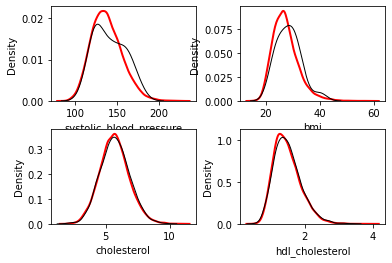

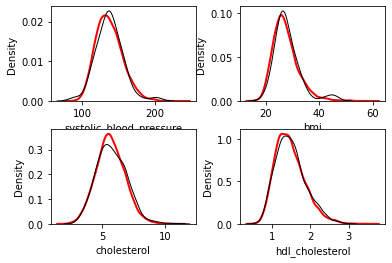

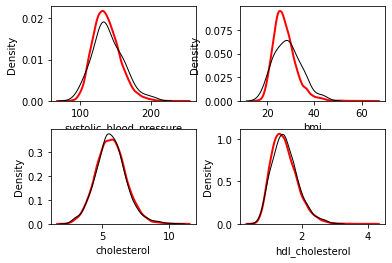

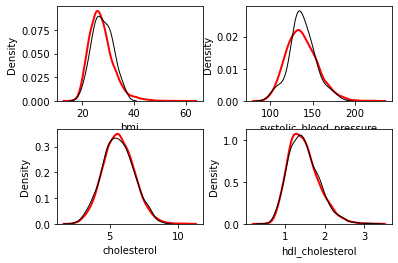

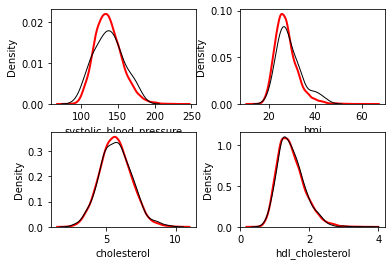

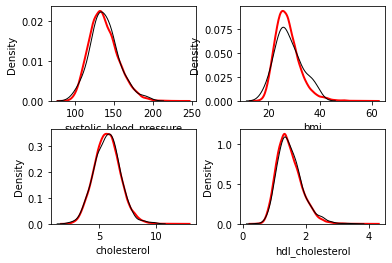

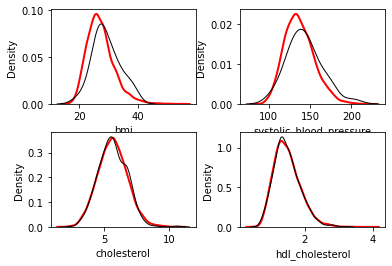

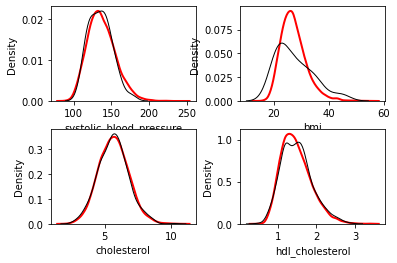

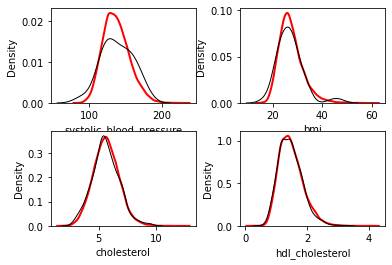

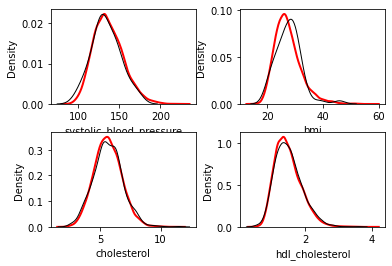

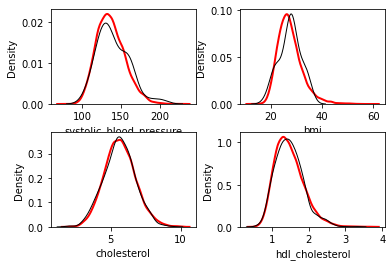

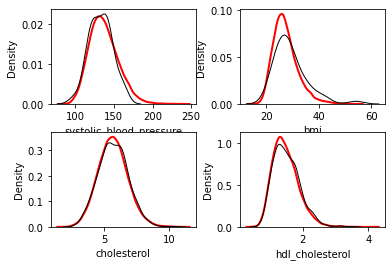

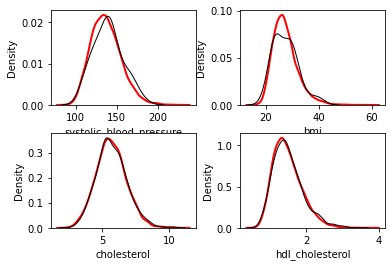

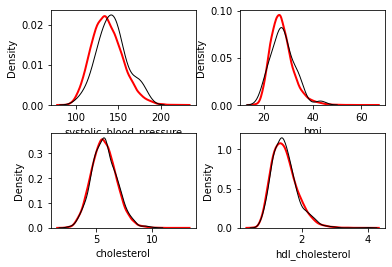

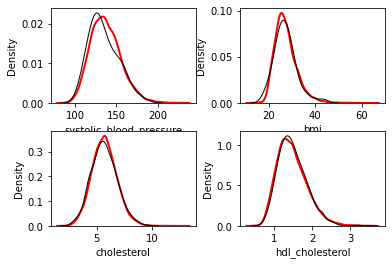

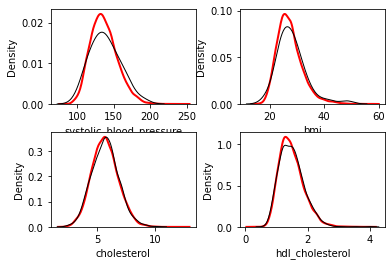

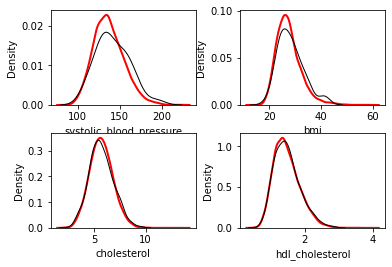

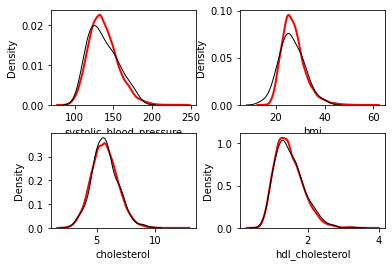

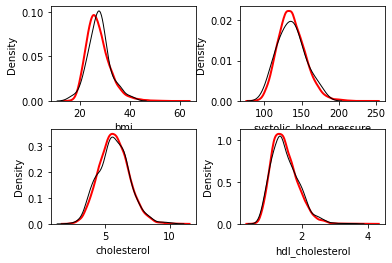

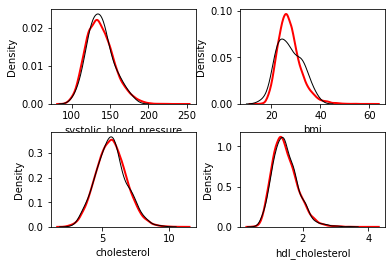

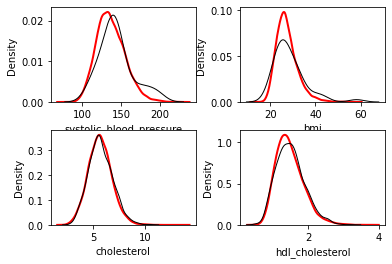

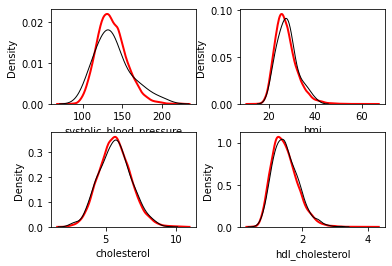

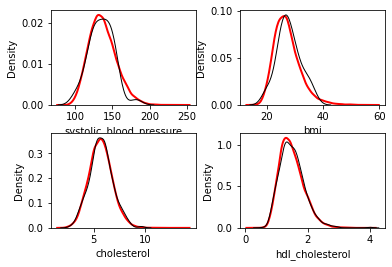

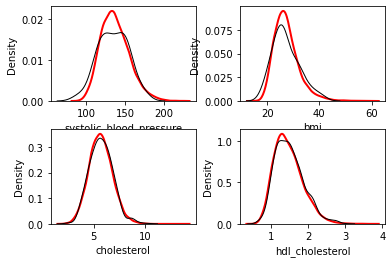

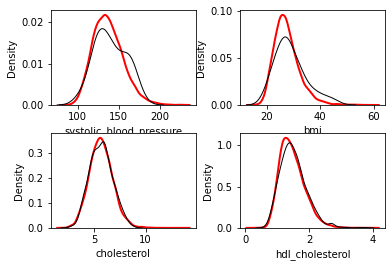

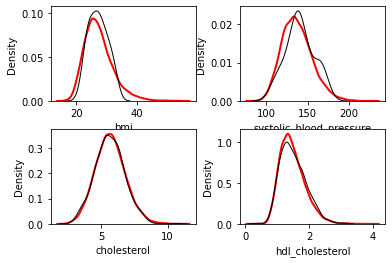

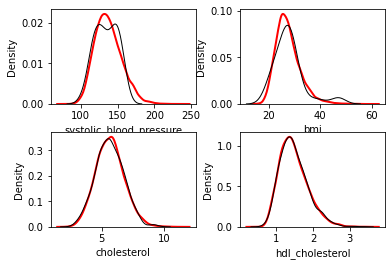

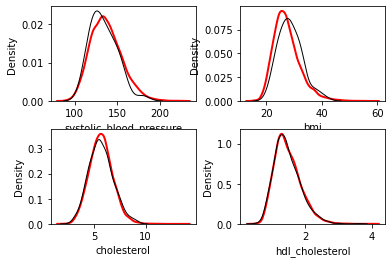

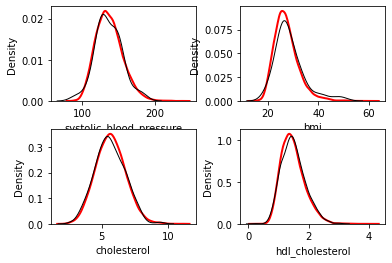

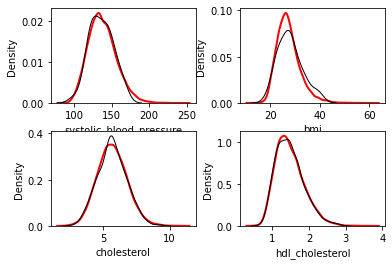

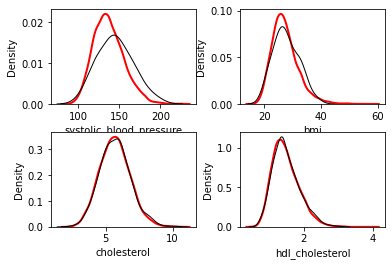

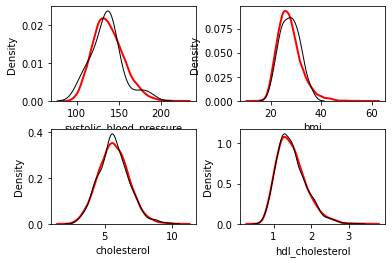

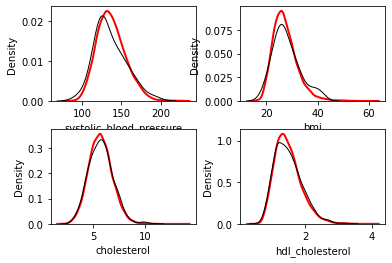

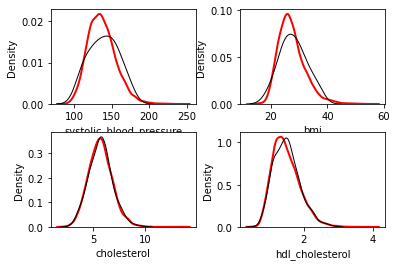

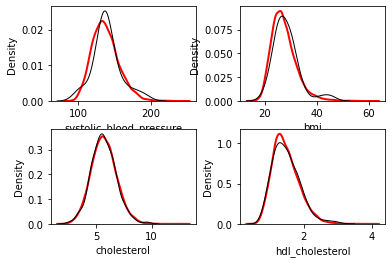

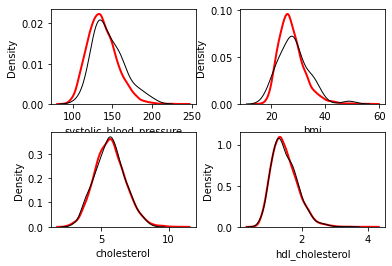

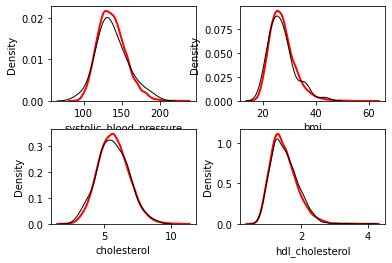

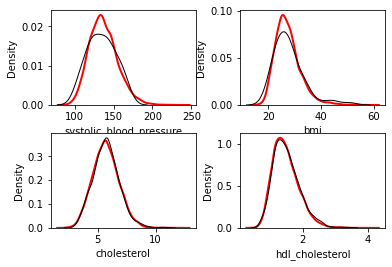

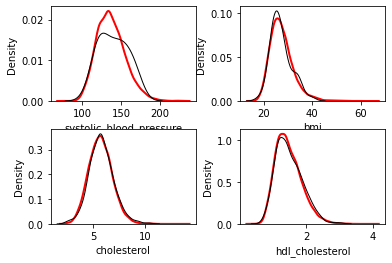

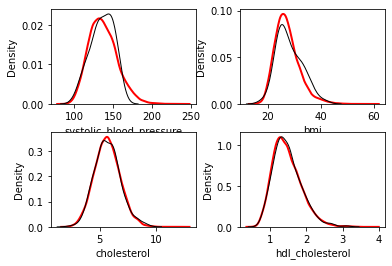

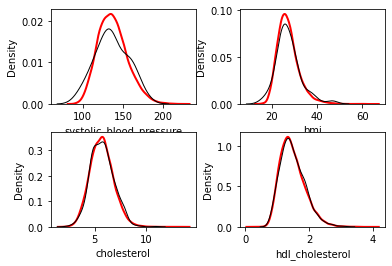

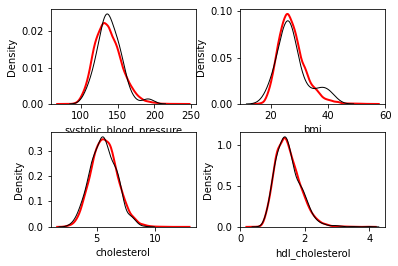

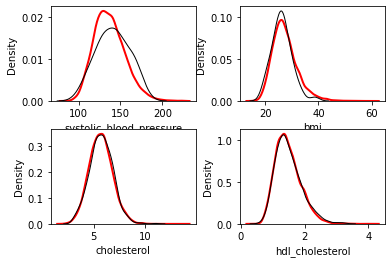

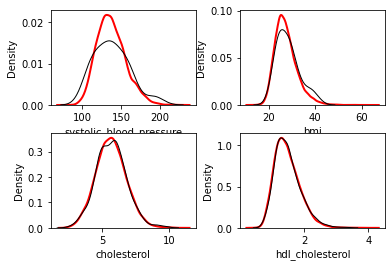

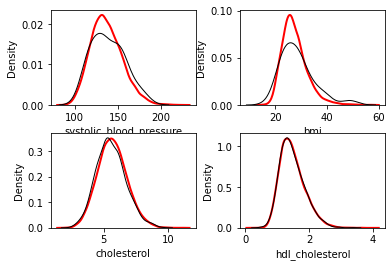

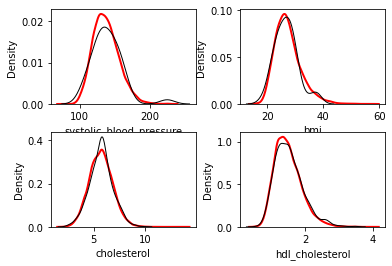

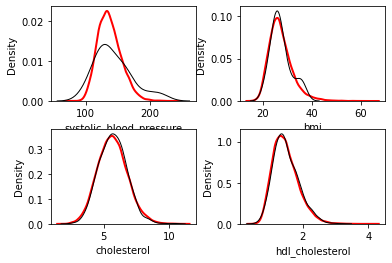

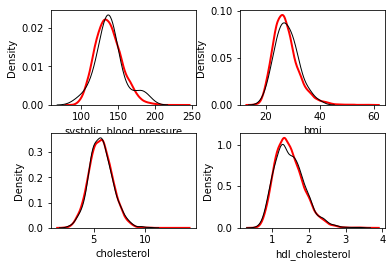

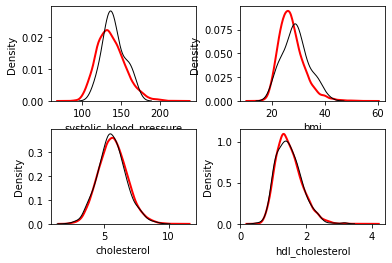

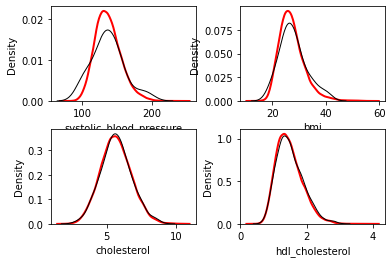

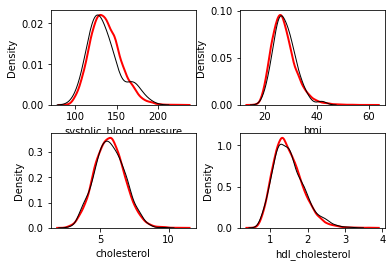

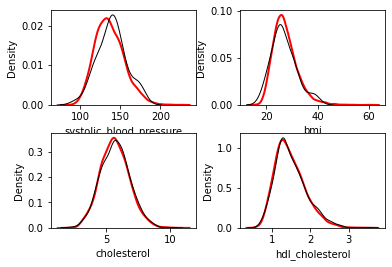

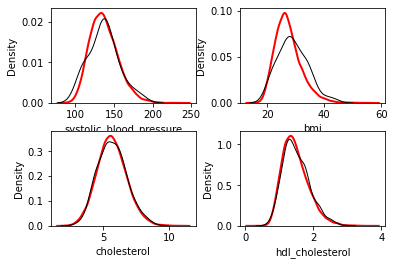

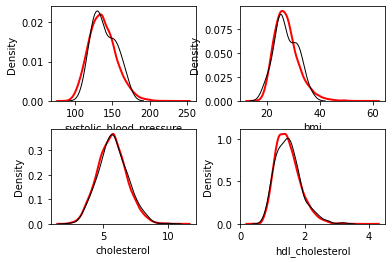

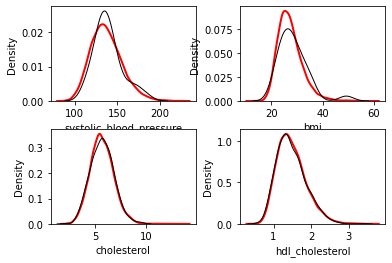

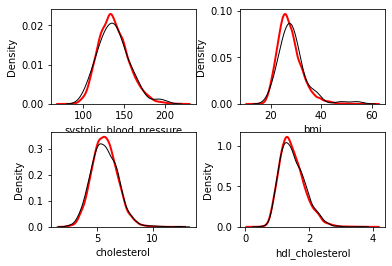

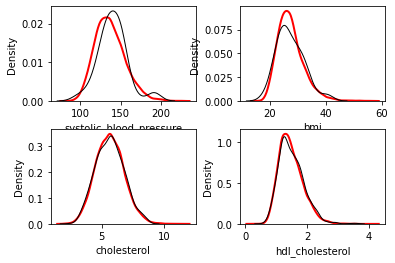

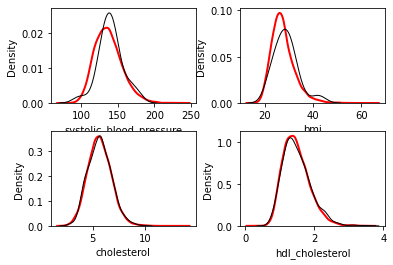

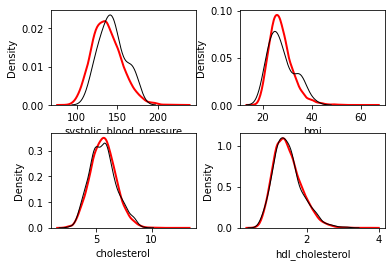

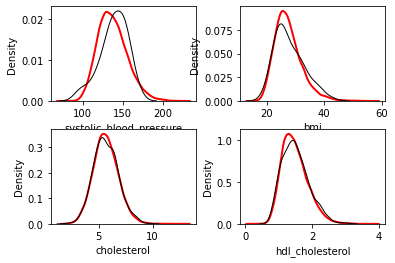

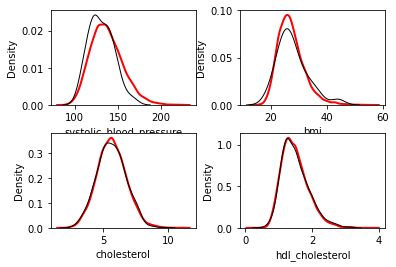

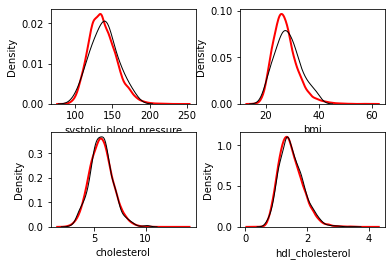

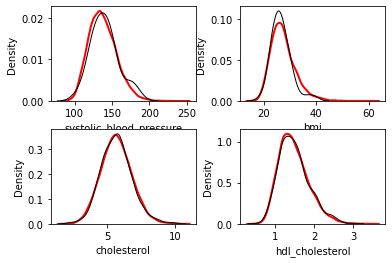

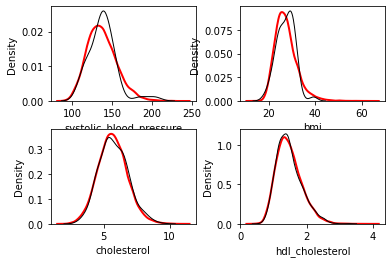

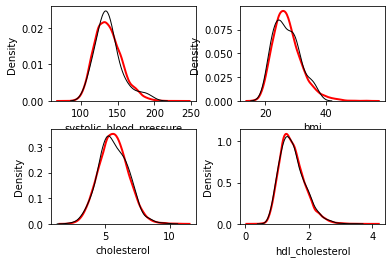

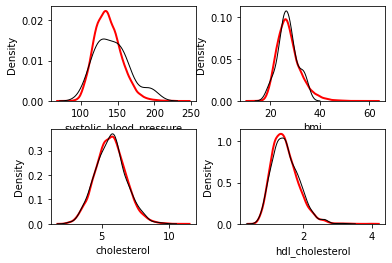

In [71]:
norm_logh_and_extra(data_covariates, variables_cont, variables_cat, 10000)

In [73]:
import sklearn
sklearn.__version__

'1.0.1'

In [74]:
1+1

2